---
# Autora 🖋️: Daniela Toro Rivera
---

## Instalaciones previas

In [ ]:
# Instalación de librerías necesarias
!pip install numpy==1.26.4 fsspec==2023.9.2 transformers datasets evaluate accelerate bitsandbytes transformers-interpret scikit-learn

# Tracking automático
import os
os.environ["WANDB_DISABLED"] = "true"
# import wandb
# import os
# wandb.login(key="6d0b3d2efabaef739e727e16c1a548ed79969150")

## Imports

In [ ]:
# Configuración de entorno reproducible
import random
import numpy as np
import torch

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud

# Preprocesamiento
import re
import string
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_es = stopwords.words('spanish')

# Manipulación de datos
import pandas as pd
from IPython.display import display

# NLP
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (
    accuracy_score, f1_score,
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay
)

# Transformers y Datasets
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from transformers_interpret import SequenceClassificationExplainer
from datasets import load_dataset

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Enunciado

En este ejercicio vamos a trabajar con un conjunto de datos procedente de medios sociales online.

Utilizaremos un subconjunto de los datos de la tarea 1 del shared task [**ProfNER**](https://temu.bsc.es/smm4h-spanish), centrada en la detección de menciones a profesiones en tweets publicados durante la pandemia del COVID-19. El objetivo original de la tarea era analizar que profesiones podrían haber sido especialmente vulnerables en el contexto de la crisis sanitaria.

La tarea será entrenar un clasificador binario basado en la arquitectura Transformers, que, dado un tweet, determine si contiene una mención explícita a una profesión (etiqueta `1`) o no (etiqueta `0`).




# Resolución

## Obtención de datos

Descargamos los datos del [repositorio de Huggingface](https://huggingface.co/datasets/luisgasco/profner_classification_master).

In [ ]:
#NO-MODIFY: DATA LOAD
from datasets import load_dataset, Dataset, DatasetDict, ClassLabel
dataset = load_dataset("luisgasco/profner_classification_master")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


El dataset contiene tres subsets:
- **train** y **validation**: Contienen el identificador del tweet, el texto, y su etiqueta, que podrá tener valor 1, si contiene una mención de una profesión; o valor 0, si no contiene una mención de una profesión.
- **test**: El test set tambiíen contiene la información de label por un requerimiento de Huggingface, pero el contenido de esta variable es siempre "-1". Es decir que deberéis predecir nuevas etiquetas una vez hayáis entrenado el modelo utilizando el train y el validation set.

## Análisis exploratorio de datos

Para hacer el análisis exploratorio de datos, transformo cada subset a un pandas dataframe para mayor comodidad.

In [ ]:
#NO-MODIFY: DATA LOAD
dataset_train_df = dataset["train"].to_pandas()
dataset_val_df = dataset["validation"].to_pandas()
dataset_test_df = dataset["test"].to_pandas()

**Primer contacto**

In [ ]:
# Muestras
muestra_con_profesion = dataset_train_df[dataset_train_df["label"] == 1]["text"].sample(5, random_state=42).reset_index(drop=True)
muestra_sin_profesion = dataset_train_df[dataset_train_df["label"] == 0]["text"].sample(5, random_state=42).reset_index(drop=True)

tabla = pd.DataFrame({
    "CON_PROFESION (label=1)": muestra_con_profesion,
    "SIN_PROFESION (label=0)": muestra_sin_profesion
})
display(tabla)

,CON_PROFESION (label=1),SIN_PROFESION (label=0)
0,"Por si había alguna duda : sí , lo que buscaba...",Lleva confinado demasiado tiempo . La mafia le...
1,Me cansé ... HILO con los vídeos que la 📺 @24h...,La cadena pública 🇮 🇹 @RaiUno lanza un pgma es...
2,"Solo sé , la prueba esté a la vista , que ni e...","🎶 Io , io , el tal Tedros Adhamón/ io , io , a..."
3,"El verano llegó , ¿ se termina la pandemia ? C...",¡ Ya se ha desbloqueado « Hielo Negro » para H...
4,Covid España : 1 . Primera en ritmo de contagi...,A partir de las 17.30 h. https://t.co/bBF2XRHU6R


Se observa a primera vista que los tweets poseen una estructura variada, la mayoría claramente relacionados a la época de pandemia y con diferentes tipos de estilo de escritura.

**Número de documentos**

In [ ]:
#MODIFY: ADD INFO TO SOLVE FUNCTION
def get_num_docs_evaluation(dataset_df):
  num_docs = len(dataset_df)
  return num_docs

In [ ]:
# Aplico la función
print(f"El Dataset de Training (dataset_train_df) tiene {get_num_docs_evaluation(dataset_train_df)} documentos")
print(f"El Dataset de Validation (dataset_val_df) tiene {get_num_docs_evaluation(dataset_val_df)} documentos")

El Dataset de Training (dataset_train_df) tiene 2786 documentos
El Dataset de Validation (dataset_val_df) tiene 999 documentos


**Número de documentos duplicados**

In [ ]:
#MODIFY: ADD INFO TO SOLVE FUNCTION
def detect_duplicates_evaluation(dataset_df):
  num_text_duplicates = dataset_df.duplicated(subset=["text"]).sum()
  num_id_duplicates = dataset_df.duplicated(subset=["tweet_id"]).sum()
  num_duplicates = num_text_duplicates + num_id_duplicates
  return num_duplicates

In [ ]:
# Aplico la función y elimino duplicados si existen
print(f"El Dataset de Training (dataset_train_df) tiene {detect_duplicates_evaluation(dataset_train_df)} elementos duplicados")
print(f"El Dataset de Validation (dataset_val_df) tiene {detect_duplicates_evaluation(dataset_val_df)} elementos duplicados")

# Elimino duplicados de Train si existen
dataset_train_df = dataset_train_df.drop_duplicates(subset=["text"])
dataset_val_df = dataset_val_df.drop_duplicates(subset=["tweet_id"])

print(f"Después de quitar duplicados, tenemos un conjunto de {dataset_train_df.shape[0]} documentos en el Dataset de Training (dataset_train_df)")
print(f"Después de quitar duplicados, tenemos un conjunto de {dataset_val_df.shape[0]} documentos en el Dataset de Validation (dataset_val_df)")

El Dataset de Training (dataset_train_df) tiene 0 elementos duplicados
El Dataset de Validation (dataset_val_df) tiene 0 elementos duplicados
Después de quitar duplicados, tenemos un conjunto de 2786 documentos en el Dataset de Training (dataset_train_df)
Después de quitar duplicados, tenemos un conjunto de 999 documentos en el Dataset de Validation (dataset_val_df)


**Comprobación de Nulls**

In [ ]:
null_texts_train = dataset_train_df["text"].isnull().sum()
null_labels_train = dataset_train_df["label"].isnull().sum()

print(f"Hay {null_texts_train} valores vacíos en los textos y {null_labels_train} valores vacíos en las etiquetas en los datos de entrenamiento.")

Hay 0 valores vacíos en los textos y 0 valores vacíos en las etiquetas en los datos de entrenamiento.


In [ ]:
null_texts_val = dataset_val_df["text"].isnull().sum()
null_labels_val = dataset_val_df["label"].isnull().sum()

print(f"Hay {null_texts_val} valores vacíos en los textos y {null_labels_val} valores vacíos en las etiquetas en los datos de entrenamiento.")

Hay 0 valores vacíos en los textos y 0 valores vacíos en las etiquetas en los datos de entrenamiento.


**Número de documentos por cada clase:**

In [ ]:
#MODIFY: ADD INFO TO SOLVE FUNCTION
def analyse_num_labels_evaluation(dataset_df):
  label_counts = dataset_df["label"].value_counts().sort_index()
  num_negatives = label_counts.get(0, 0)
  num_positives = label_counts.get(1, 0)
  print(f"Número de labels positivos (CON_PROFESION 1): {num_positives}")
  print(f"Número de labels negativos (SIN_PROFESION 0): {num_negatives}")

  fig = px.bar(
        x=["SIN_PROFESION (0)", "CON_PROFESION (1)"],
        y=[num_negatives, num_positives],
        text=[num_negatives, num_positives],
        title="Distribución de clases en el dataset",
        labels={"x": "Etiqueta", "y": "Cantidad"},
        color=["SIN_PROFESION (0)", "CON_PROFESION (1)"],
        color_discrete_map={"SIN_PROFESION (0)": "blue", "CON_PROFESION (1)": "orange"}
    )
  fig.update_traces(textposition="outside")
  fig.show()

  return num_positives, num_negatives

In [ ]:
# Aplico la función
print("Dataset de Training (dataset_train_df)")
print(analyse_num_labels_evaluation(dataset_train_df))

Dataset de Training (dataset_train_df)
Número de labels positivos (CON_PROFESION 1): 1393
Número de labels negativos (SIN_PROFESION 0): 1393


(1393, 1393)


No hay desbalance de clases

In [ ]:
print("Dataset de Validation (dataset_val_df)")
print(analyse_num_labels_evaluation(dataset_val_df))

Dataset de Validation (dataset_val_df)
Número de labels positivos (CON_PROFESION 1): 238
Número de labels negativos (SIN_PROFESION 0): 761


(238, 761)


Se obseerva un desbalance de clases, la clase CON_PROFESIÓN (1) posee 238 instancias (23.8%), mientras que SIN_PROFESIÓN (0) posee unas 761 instancias (76.2%), esto puede generar sesgo en la clase mayoritaria. Por tanto, una métrica como accuracy puede ser engañosa y debería tenerse en cuenta el F1 para valorar la calidad del modelo

**Distribución de la longitud de los tweet en caracteres:**

<Figure size 1400x1200 with 0 Axes>

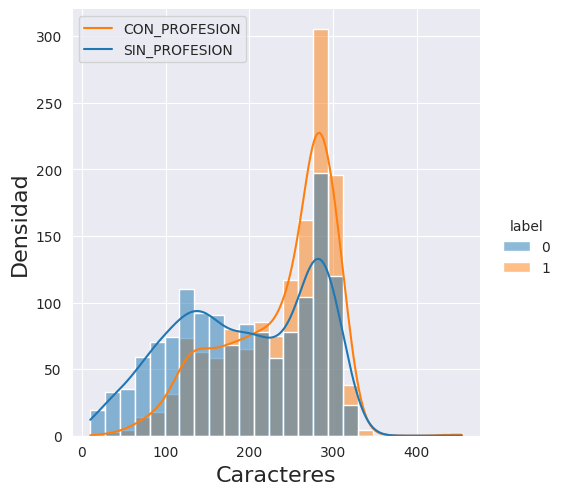

In [ ]:
# Análisis de dataset_train_df
dataset_train_df["char_len"] = dataset_train_df["text"].apply(lambda x: len(x))

fig = plt.figure(figsize=(14,12))
sns.set_style("darkgrid")
sns.displot(data=dataset_train_df, x="char_len", hue="label", kde=True, legend=True)
plt.legend(["CON_PROFESION", "SIN_PROFESION"])
plt.xlabel('Caracteres', fontsize=16)
plt.ylabel('Densidad', fontsize=16)
plt.show()

En el caso de los Tweets de dataset_train_df , la mayoría de documentos tienen una longitud muy reducida (menos de 300 caracteres). Comparando las longitudes de los documentos asociados a cada categoría, se aprecia que los tweets que tienen presente una profesion tienen una longitud algo mayor, concentrada la mayoria entre 250 a 300 caracteres.

<Figure size 1400x1200 with 0 Axes>

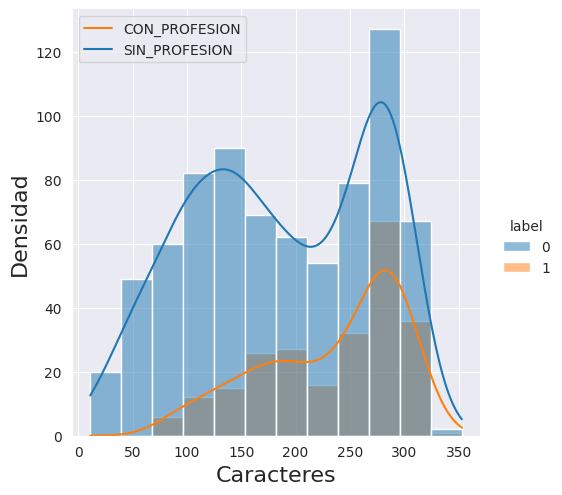

In [ ]:
# Análisis de dataset_val_df
dataset_val_df["char_len"] = dataset_val_df["text"].apply(lambda x: len(x))

fig = plt.figure(figsize=(14,12))
sns.set_style("darkgrid")
sns.displot(data=dataset_val_df, x="char_len", hue="label", kde=True, legend=True)
plt.legend(["CON_PROFESION", "SIN_PROFESION"])
plt.xlabel('Caracteres', fontsize=16)
plt.ylabel('Densidad', fontsize=16)
plt.show()

En contrapartida del análisis anterior, las longitudes de los documentos asociados a cada categoría en dataset_val_df, se aprecia que los tweets que NO tienen presente una profesion tienen una longitud mayor. Se mantiene que en ambos casos la longitud es muy reducida (menos de 300 caracteres la mayoría).

**Análisis de contenido de los tweets con wordclouds**

In [ ]:
# Sobre Train
txt_cat0 = ",".join(dataset_train_df[dataset_train_df.label==0].text.to_list())
txt_cat1 = ",".join(dataset_train_df[dataset_train_df.label==1].text.to_list())

In [ ]:
es_stopwords = stopwords.words('spanish')
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=0,
                      contour_color='steelblue', stopwords=es_stopwords,
                      normalize_plurals = True)

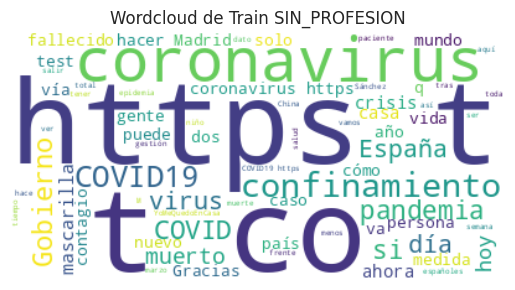

In [ ]:
# Clase SIN_PROFESION
wordcloud.generate(txt_cat0)
wordcloud.to_image()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud de Train SIN_PROFESION")
plt.show()

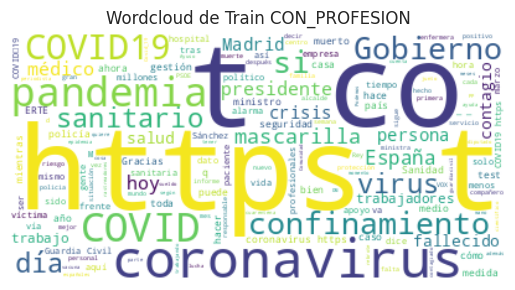

In [ ]:
# Clase CON_PROFESION
wordcloud.generate(txt_cat1)
wordcloud.to_image()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud de Train CON_PROFESION")
plt.show()

Observando los resultados, vemos los siguientes fenómenos:
  - En el wordcloud de la categoría 0 se observa que hay una alta presencia de URLs (presencia de *https*, *co* y *t* ), así como de la palabra *coronavirus*, *confinamiento* y *COVID19*. Son términos que no muestran profesiones. El resto de términos están asociados a características político-sociales del momento pero no hacen referencias a profesiones de maner directa. Existen algunos términos como *gobierno* que puede tener relación con profesión.
  - En el wordcloud asociado a la categoría 1 se observa una alta presencia de URLs (presencia de *https*, *co* y *t* ), lo que muestra que habrá igual presencia de estas en esta categoría. Predominan términos como *coronavirus*, *confinamiento* y *COVID19*, también presentes en la categoría 0. Aparecen sustantivos que expresan profesiones de manera clara como *médico*, *presidente*, o *policia*.

En general, se obserban similitudes en términos presentes en ambos grupos (https, coronavirus, co, t, gobierno, COVID19, confinamiento, mascarilla), pero varias diferencias en el resto del contenido.


**Unigramas más frecuentes cada clase**

In [ ]:
def visualizar_top_ngrams(dataset_df, columna_texto="text", top_n=20):
    textos = dataset_df[columna_texto].dropna().astype(str)

    def obtener_top_ngrams(corpus, ngram_range=(1,1), top_n=20):
        vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words=stopwords_es)
        X = vectorizer.fit_transform(corpus)
        suma = X.sum(axis=0)
        conteos = [(ngram, int(suma[0, idx])) for ngram, idx in vectorizer.vocabulary_.items()]
        return Counter(dict(conteos)).most_common(top_n)

    def graficar_ngrams(top_ngrams, titulo):
        ngramas, frecuencias = zip(*top_ngrams)
        plt.figure(figsize=(10, 6))
        sns.barplot(x=frecuencias, y=ngramas, palette="rocket")
        plt.title(titulo, fontsize=16)
        plt.xlabel("Frecuencia", fontsize=12)
        plt.ylabel("N-gramas", fontsize=12)
        plt.tight_layout()
        plt.show()

    top_unigramas = obtener_top_ngrams(textos, ngram_range=(1, 1), top_n=top_n)
    graficar_ngrams(top_unigramas, f"Top {top_n} Unigramas")

<ipython-input-21-851406102>:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




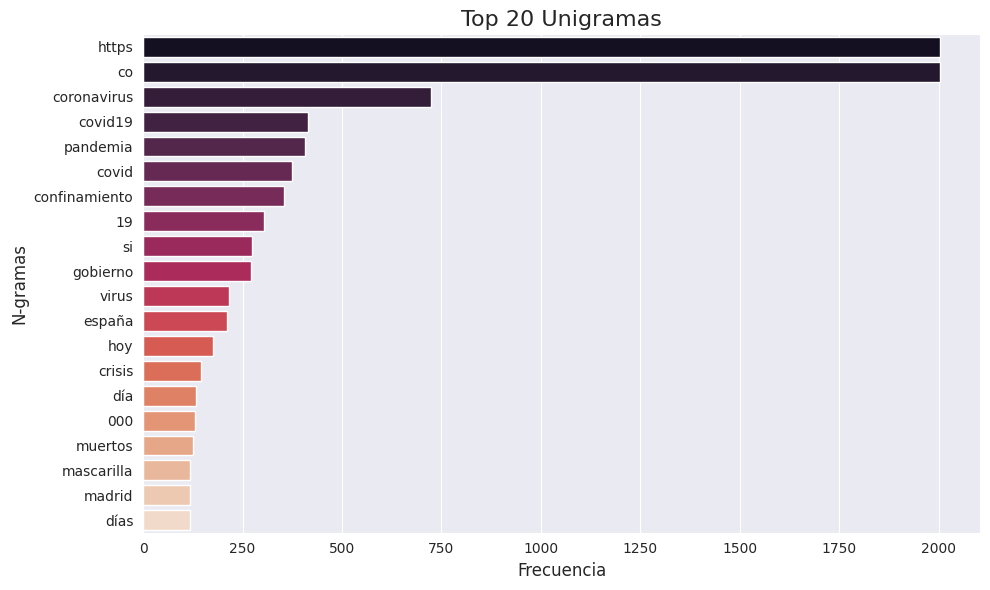

In [ ]:
visualizar_top_ngrams(dataset_train_df)

Las palabras más comunes son https y co, ambas relacionadas a las caracteristicas estructurales de los tweet y que están presentes en todos los elementos de los df, tal como se observó anteriormente en el Wordcloud. El resto de terminos más comunes a modo general se asocian a características políticas y sociales del momento, sin hacer referencia a una profesión en específica.

**Palabras más relevantes de train**



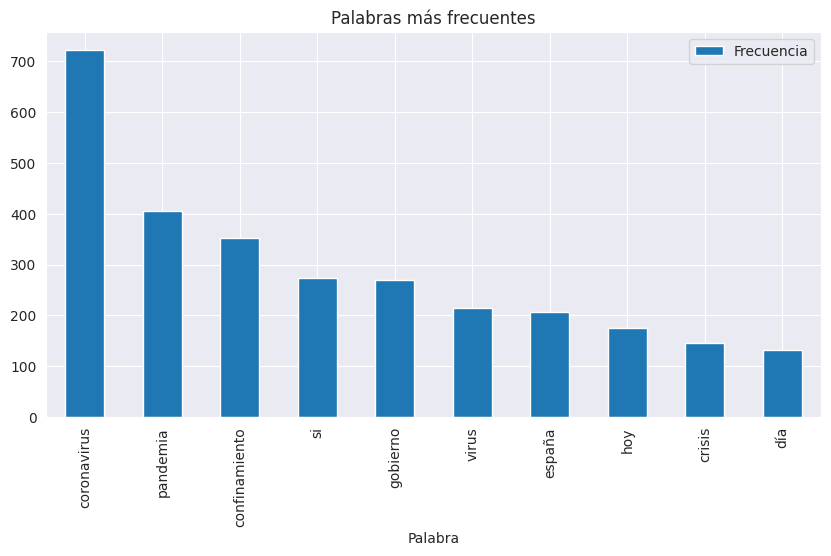

In [ ]:
# Tokenización para conteo de palabras
tokens = " ".join(dataset_train_df["text"]).lower().split()
tokens = [word for word in tokens if word.isalpha() and word not in stopwords_es]
counter = Counter(tokens)

# Top 10
pd.DataFrame(counter.most_common(10), columns=["Palabra", "Frecuencia"]).plot(
    x="Palabra", y="Frecuencia", kind="bar", figsize=(10,5), title="Palabras más frecuentes"
    )
plt.show()

Si realizamos una tokenización previa y eliminamos stopwords obtenemos una vision más exacta de las palabras más frecuentes de la muestra, lo que permite identificar la temática general de los temas que se tratan.

**Palabras más importantes por label**

In [ ]:
def palabras_comunes_por_label(df, texto_col="text", label_col="label", top_n=30):
    vect = CountVectorizer(stop_words=stopwords_es)
    X = vect.fit_transform(df[texto_col])
    palabras = vect.get_feature_names_out()

    idx_0 = (df[label_col] == 0).to_numpy().nonzero()[0]
    idx_1 = (df[label_col] == 1).to_numpy().nonzero()[0]

    X_0 = X[idx_0]
    X_1 = X[idx_1]

    freq_0 = X_0.sum(axis=0).A1
    freq_1 = X_1.sum(axis=0).A1

    df_freq = pd.DataFrame({
        "palabra": palabras,
        "label_0": freq_0,
        "label_1": freq_1
    })

    df_top = df_freq.sort_values(["label_0", "label_1"], ascending=False).head(top_n)

    fig = px.scatter(df_top, x="label_0", y="label_1", text="palabra",
                     labels={"label_0": "Frecuencia en clase 0", "label_1": "Frecuencia en clase 1"},
                     title="Palabras más comunes por clase")
    fig.update_traces(textposition="top center")
    fig.show()

In [ ]:
# Elimino https y co para mejor visualizacion
dataset_train_df_clean = dataset_train_df.copy()
dataset_train_df_clean["text"] = dataset_train_df_clean["text"].apply(lambda x: re.sub(r"https?://\S+|www\.\S+", "", x))
palabras_comunes_por_label(dataset_train_df_clean)

Observando la estructura de la frecuencia de aparicion de cada palabra segun cada clase, se observa que palabras como pandemia y covid estan altamente presentes en la clase 1, mientras que la clase 2 tiene alta presencia de términos como confinamiento. La palabra coronavirus está altamente presente en ambas clases, lo cual tiene sentido ya que es el tema general, pero no sirve como factor discriminante.

## Tokenización

**Limpieza previa**

Al inicio tuve muchas dudas de si era realmente necesario realizar una limpieza. En la página oficial del modelo dccuchile/bert-base-spanish-wwm-cased no se menciona limpieza profunda previa, solo se indica que el tokenizador se encargará del procesamiento.

No hay un documento oficial único que diga explícitamente **"BETO no necesita limpieza profunda"**, pero la recomendación general para modelos BERT (y sus variantes como BETO) proviene de la documentación oficial de BERT y buenas prácticas en NLP.

No realizaré una limpieza muy fuerte como eliminar signos de puntuación, convertir todo a minúsculas o quitar stopwords dado que BETO (como BERT en general) fue entrenado con texto “natural”, que incluye puntuación, mayúsculas/minúsculas e incluso errores. Si quitaré caracteres o símbolos que no aporten información o estén muy raros como URLs mal formateadas, emojis raros, códigos HTML, muchos espacios, etc.

Para BETO, que es una versión de BERT para español, estas recomendaciones se basan en:

- El paper original de BERT ([https://arxiv.org/abs/1810.04805](https://arxiv.org/abs/1810.04805)) explica que BERT usa tokenización basada en WordPiece, que maneja muy bien palabras con puntuación, mayúsculas, etc., y no necesita limpieza de stopwords o stemming.

- En el repositorio de BETO en HuggingFace ([https://huggingface.co/dccuchile/bert-base-spanish-wwm-cased](https://huggingface.co/dccuchile/bert-base-spanish-wwm-cased)), aunque no explicita las recomendaciones de limpieza, sigue la misma lógica de BERT.

- La comunidad y tutoriales relacionados, recalcan que no es necesaria la limpieza agresiva.

- También, en general, para transformers y modelos de HuggingFace ([https://huggingface.co/docs/transformers/preprocessing](https://huggingface.co/docs/transformers/main/en/preprocessing)) se recomienda sólo limpieza ligera antes de tokenizar.



In [ ]:
'''
# Limpieza de textos
def df_cleaning(texto):
    # Eliminar menciones y hashtags
    texto = re.sub(r"@\w+", "", texto)
    texto = re.sub(r"#\w+", "", texto)
    # Eliminar URLs
    texto = re.sub(r"http\S+|www\S+|https\S+", "", texto)
    # Eliminar puntuación
    texto = texto.translate(str.maketrans("", "", string.punctuation))
    # Eliminar números
    texto = re.sub(r"\d+", "", texto)
    # Eliminar espacios múltiples
    texto = re.sub(r"\s+", " ", texto).strip()
    return texto
dataset_train_df["text_clean"] = dataset_train_df["text"].apply(df_cleaning)
dataset_val_df["text_clean"] = dataset_val_df["text"].apply(df_cleaning)
'''

'\n# Limpieza de textos\ndef df_cleaning(texto):\n    # Eliminar menciones y hashtags\n    texto = re.sub(r"@\\w+", "", texto)\n    texto = re.sub(r"#\\w+", "", texto)\n    # Eliminar URLs\n    texto = re.sub(r"http\\S+|www\\S+|https\\S+", "", texto)\n    # Eliminar puntuación\n    texto = texto.translate(str.maketrans("", "", string.punctuation))\n    # Eliminar números\n    texto = re.sub(r"\\d+", "", texto)\n    # Eliminar espacios múltiples\n    texto = re.sub(r"\\s+", " ", texto).strip()\n    return texto\ndataset_train_df["text_clean"] = dataset_train_df["text"].apply(df_cleaning)\ndataset_val_df["text_clean"] = dataset_val_df["text"].apply(df_cleaning)\n'

EDIT: Después de probar con el modelo con limpieza y sin limpieza, decido trabajar sin limpiar, ya que en Train obtuve peores métricas aplicando df_cleaning, adjunto dichas métricas a continuación:

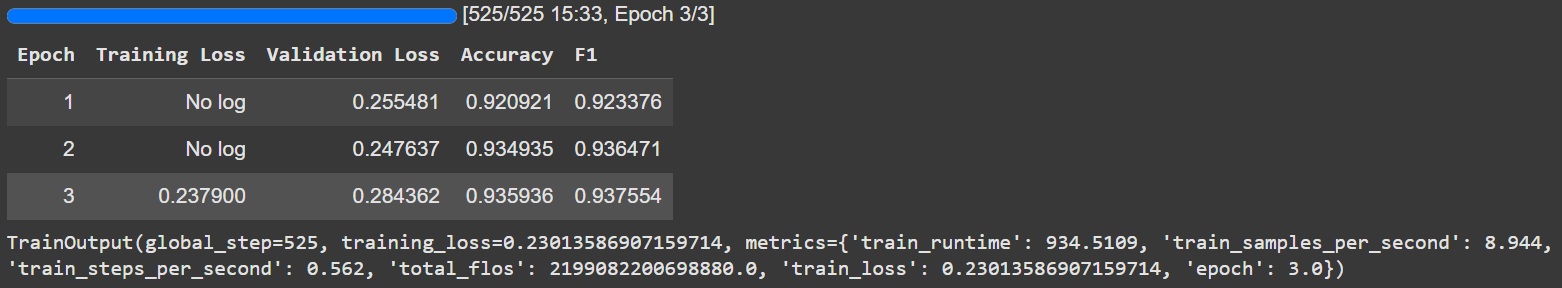

**Seleccion de un modelo apropiado**

In [ ]:
#NO-MODIFY: VARIABLE NAME
model_name = "dccuchile/bert-base-spanish-wwm-cased"

**Justificación del modelo** :

Modelos del mercado encontrados:

| Modelo                  | Arquitectura   | Idioma / Entrenamiento                  | Tamaño (params) | Ventajas Principales                                                                 | Desventajas                                                  | Documentación |
|------------------------|----------------|-----------------------------------------|-----------------|---------------------------------------------------------------------------------------|---------------------------------------------------------------|---------------|
| [**BETO**](https://huggingface.co/dccuchile/bert-base-spanish-wwm-cased) | BERT-base      | Español (Wikipedia + libros)            | ~110M          | Entrenado 100% en español; buen desempeño general                                    | No adaptado a lenguaje informal (ej. Twitter)                 | BETO 🇪🇸       |
| [**BERTin**](https://huggingface.co/bertin-project/bertin-roberta-base-spanish) | RoBERTa-base   | Español (Oscar + Wikipedia)             | ~125M          | Entrenado desde cero en español; robusto                                             | Menos probado que BETO                                       | BERTin 🇪🇸     |
| [**MarIA**](https://huggingface.co/PlanTL-GOB-ES/roberta-base-bne) | RoBERTa-base   | Español (RAE + Wikipedia + C4)          | ~135M          | Excelente comprensión lingüística en español                                        | Modelo grande; más lento                                      | MarIA 🇪🇸      |
| [**TweetEval (es)**](https://huggingface.co/cardiffnlp/twitter-xlm-roberta-base-sentiment) | XLM-RoBERTa    | Multilingüe + Twitter                    | ~270M          | Entrenado en tweets; bueno para emociones, odio, ironía                              | Modelo pesado; requiere más recursos                          | TweetEval 🐦  |
| [**XLM-RoBERTa**](https://huggingface.co/xlm-roberta-base) | RoBERTa        | Multilingüe (100 idiomas)               | ~270M          | Cobertura multilingüe; decente en español                                            | Menos preciso que modelos dedicados a español                 | XLM-R 🗺️      |
| [**DistilBETO**](https://huggingface.co/mrm8488/distilbert-base-spanish-uncased-finetuned-spa-squad2-es) | DistilBERT     | Español (modelo reducido de BETO)       | ~66M           | Rápido y liviano; ideal para producción                                               | Algo menos preciso que BETO                                   | DistilBETO ⚡  |

Debido a las características de todos los modelos, finalmente seleccioné el siguiente para el desarrollo del proyecto:

[BETO - dccuchile/bert-base-spanish-wwm-cased](https://huggingface.co/dccuchile/bert-base-spanish-wwm-cased)
- Entrenado exclusivamente en español, con corpus de alta calidad.

- Muy buen rendimiento en tareas de clasificación de texto en español.

- Tamaño manejable para entrenamiento en Google Colab (base, no muy pesado).

- Su Whole Word Masking mejora la comprensión de palabras compuestas, común en tweets.

- Es un modelo muy usado en la comunidad NLP en español, fácil encontrar tutoriales y soporte.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Convierto a dataset
train_dataset = Dataset.from_pandas(dataset_train_df)
val_dataset = Dataset.from_pandas(dataset_val_df)

def tokenize_function(example):
    return tokenizer(
        example["text"], # Pongo "text_clean" solo para el caso de que no sea con el limpio
        padding="max_length",
        truncation=True
    )

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# Formato para PyTorch
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/2786 [00:00<?, ? examples/s]

Map:   0%|          | 0/999 [00:00<?, ? examples/s]

Los 2786 ejemplos (tweets) han sido tokenizado en una secuencia de longitud 154 tokens. Esto incluye tokens reales del texto y tokens especiales como [CLS] y [SEP] + relleno ([PAD]) hasta alcanzar esa longitud fija (padding).
La attention mask también tiene el mismo tamaño. Indica con 1 los tokens que deben ser atendidos y con 0 los que son padding ([PAD]).

## Fine-tuning

Carga del model para ser ajustado posteriormente

In [ ]:
id2label = {0: "SIN_PROFESION", 1: "CON_PROFESION"}
label2id = {"SIN_PROFESION": 0, "CON_PROFESION": 1}
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Configuracion training_args

Configuracion de los parámetros de entrenamiento del modelo.


>

In [ ]:
#NO-MODIFY: VARIABLE NAME
training_args = TrainingArguments(
    output_dir="./modelo_beto",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    #metric_for_best_model="accuracy",
    save_total_limit=2,
    seed=42
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


### Métricas de evaluación

Definicion de las métricas de evaluación

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='weighted')
    }

### Ajuste del modelo

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.198301,0.937938,0.939080
2,No log,0.229826,0.935936,0.937484
3,0.243300,0.268472,0.934935,0.936543


TrainOutput(global_step=525, training_loss=0.2343058374949864, metrics={'train_runtime': 885.0998, 'train_samples_per_second': 9.443, 'train_steps_per_second': 0.593, 'total_flos': 2199082200698880.0, 'train_loss': 0.2343058374949864, 'epoch': 3.0})

El modelo fue entrenado durante 3 épocas, alcanzando una pérdida de entrenamiento (training loss) de 0.2343, lo que indica un buen ajuste a los datos de entrenamiento.

Durante la tercera época se obtuvieron los siguientes resultados de evaluación:

- F1-score: 0.9391

- Pérdida de validación (eval loss): 0.1983

Estos valores reflejan un rendimiento sólido del modelo, especialmente considerando el contexto de análisis de tweets en español, donde el lenguaje es informal, ambiguo y con alto nivel de ruido. La baja diferencia entre la pérdida de entrenamiento y la de validación sugiere que el modelo no está sobreajustado y conserva una buena capacidad de generalización.

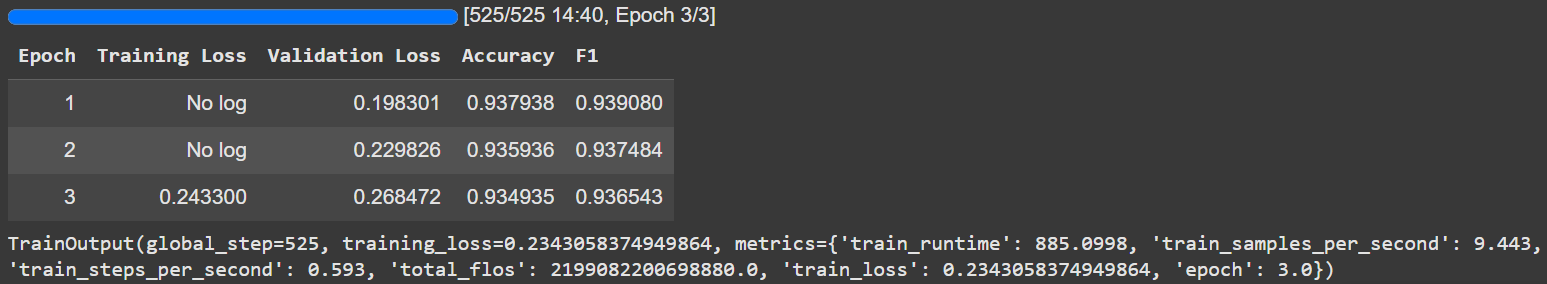

In [ ]:
trainer.save_model("output_model_save")

## Evaluacion

In [ ]:
eval_results = trainer.evaluate()
print("Resultados de evaluación:", eval_results)

Resultados de evaluación: {'eval_loss': 0.19830133020877838, 'eval_accuracy': 0.9379379379379379, 'eval_f1': 0.9390803119049438, 'eval_runtime': 29.363, 'eval_samples_per_second': 34.022, 'eval_steps_per_second': 2.146, 'epoch': 3.0}


**Conclusiones del modelo**

| **Métrica**  | **Entrenamiento** | **Validación** | **Diferencia**                             |
| ------------ | ----------------- | -------------- | ------------------------------------------ |
| **Loss**     | 0.2343            | 0.1983         | Validación incluso mejor que entrenamiento |
| **F1 Score** | No disponible     | 0.9391         | Excelente rendimiento en datos no vistos   |
| **Accuracy** | No disponible     | 0.9379         | Alta precisión en predicción               |


**Proporción**: eval_loss es aproximadamente 0.85x el training_loss
Este valor es menor a 1, lo que indica que el modelo incluso mejora en validación, posiblemente por regularización natural o datos más sencillos en el conjunto de evaluación.

- Entrenamiento efectivo: train_loss bajo (0.2343) muestra un aprendizaje exitoso.

- Generalización fuerte: eval_loss más bajo que train_loss, sin señales de sobreajuste.

- Rendimiento sobresaliente: F1-score alto (0.9391) y accuracy cercano al 94% reflejan gran capacidad predictiva.

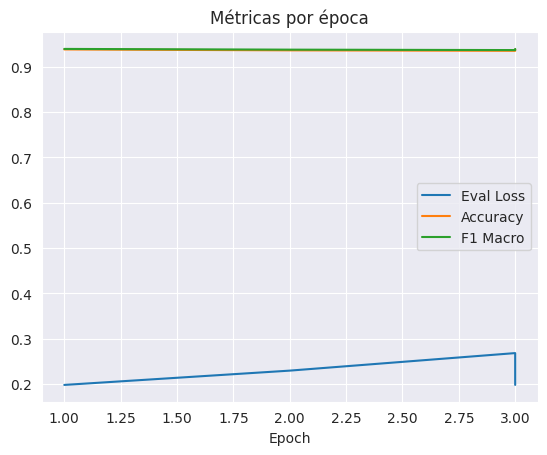

In [ ]:
logs = pd.DataFrame(trainer.state.log_history)
logs = logs.dropna(subset=["eval_loss"], axis=0)

plt.plot(logs["epoch"], logs["eval_loss"], label="Eval Loss")
plt.plot(logs["epoch"], logs["eval_accuracy"], label="Accuracy")
plt.plot(logs["epoch"], logs["eval_f1"], label="F1 Macro")
plt.xlabel("Epoch")
plt.title("Métricas por época")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
trainer.evaluate(val_dataset)

{'eval_loss': 0.19830133020877838,
 'eval_accuracy': 0.9379379379379379,
 'eval_f1': 0.9390803119049438,
 'eval_runtime': 29.4385,
 'eval_samples_per_second': 33.935,
 'eval_steps_per_second': 2.14,
 'epoch': 3.0}

- Pérdida baja: eval_loss = 0.1983, muestra que el modelo comete pocos errores en validación.

- F1 alto: 0.9391, indica un excelente balance entre precisión y recall.

- Rendimiento eficiente: el modelo evalúa rápidamente (34 muestras por segundo).

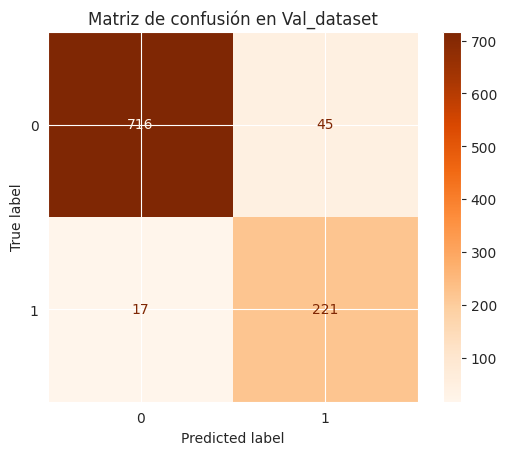

In [ ]:
pred_val = trainer.predict(val_dataset)
y_pred = np.argmax(pred_val.predictions, axis=1)
y_true = pred_val.label_ids

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Oranges")
plt.title("Matriz de confusión en Val_dataset")
plt.show()

**Interpretaciones obtenidas de la matriz:**

|                       | **Predicho: 0**            | **Predicho: 1**            |
| --------------------- | -------------------------- | -------------------------- |
| **Real: 0** (Clase 0) | ✅ **716** (True Negatives) | ❌ **45** (False Positives) |
| **Real: 1** (Clase 1) | ❌ **17** (False Negatives) | ✅ **221** (True Positives) |

✅ 716 ejemplos de clase 0 bien clasificados como 0

❌ 45 ejemplos de clase 0 mal clasificados como 1

❌ 17 ejemplos de clase 1 mal clasificados como 0

✅ 221 ejemplos de clase 1 bien clasificados como 1

In [ ]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       761
           1       0.83      0.93      0.88       238

    accuracy                           0.94       999
   macro avg       0.90      0.93      0.92       999
weighted avg       0.94      0.94      0.94       999



- Clase 0 (SIN_PROFESIÓN):

Muy buen desempeño general con un F1-score de 0.96, lo que indica que el modelo identifica correctamente esta clase con alta precisión (0.98) y buen recall (0.94).

- Clase 1 (CON_PROFESIÓN):

Aunque esta clase tiene menos ejemplos, el modelo logra un recall de 0.95, lo cual es excelente, y un F1-score decente de 0.89. Esto indica que el modelo es muy eficaz para no pasar por alto instancias de esta clase, aunque comete algunos errores de precisión (0.83).

Estos valores muestran que el modelo es bastante sólido, incluso en presencia de cierto desequilibrio entre clases.

In [ ]:
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label", "text"])
# Inicializo el explainer
explainer = SequenceClassificationExplainer(model, tokenizer)
# Texto de ejemplo por clase
text_ex_0 = dataset_val_df[dataset_val_df["label"] == 0]["text"].iloc[0]
text_ex_1 = dataset_val_df[dataset_val_df["label"] == 1]["text"].iloc[0]

In [ ]:
# Explicación para clase 0
explainer(text_ex_0)
explainer.visualize()
word_attributions = explainer(text_ex_0)
for word, score in word_attributions:
    print(f"{word:>12} : {score:.4f}")

       [CLS] : 0.0000
         600 : 0.1706
     muertos : 0.2416
     después : 0.2210
           , : -0.2154
      Suecia : 0.1761
    mantiene : 0.0993
          su : 0.0734
  estrategia : 0.0734
        ante : 0.0900
          el : 0.0910
      corona : 0.0990
       ##vir : 0.1786
        ##us : 0.2313
         sin : 0.1132
      perder : 0.0902
          la : 0.0779
       calma : 0.0503
           , : -0.1923
        pero : 0.0885
         con : 0.0839
       dudas : 0.0683
           h : 0.0279
        ##tt : 0.0882
        ##ps : 0.1605
           : : -0.1374
           / : -0.0373
           / : -0.0394
           t : 0.1153
           . : 0.0894
          co : 0.0405
           / : -0.0386
           c : 0.0362
        ##ES : 0.1354
         ##f : 0.1854
         ##O : 0.1485
        ##bo : 0.1885
         ##D : 0.2192
         ##p : 0.2352
         ##6 : 0.1833
           h : 0.0715
        ##tt : 0.1457
        ##ps : 0.2193
           : : -0.1310
           / : -0.0247
  

Interpretación
Muchos de los tokens más relevantes son fragmentos de URLs, lo cual puede ser un indicador fuerte aprendido por el modelo de que estos tweets pertenecen a la clase SIN_PROFESION. El modelo predice con mucha confianza que este tweet pertenece a la clase SIN_PROFESION y parece dar gran peso a la presencia de URLs y palabras clave como "virus", "corona", "Suecia", etc.
La estructura y los contenidos informativos más generales del tweet (ej. número de muertos, estrategia de país) también pueden estar asociados a SIN_PROFESION, ya que probablemente estos tweets no mencionan directamente una ocupación.

In [ ]:
# Explicación para clase 1
explainer(text_ex_1)
explainer.visualize()
word_attributions = explainer(text_ex_1)
for word, score in word_attributions:
    print(f"{word:>12} : {score:.4f}")

       [CLS] : 0.0000
       Entró : 0.0739
           a : 0.0191
    trabajar : 0.1986
           a : 0.0037
         una : 0.0379
  residencia : 0.0720
          de : 0.0352
    ancianos : 0.0254
           a : 0.0086
    primeros : 0.0396
          de : 0.0323
       abril : 0.0295
           . : 0.0206
          La : -0.0022
    pusieron : 0.0417
           a : 0.0499
    trabajar : 0.3380
          de : 0.2613
    auxiliar : 0.5992
          de : 0.2357
  enfermería : 0.4241
         sin : 0.0892
       tener : 0.1294
        ella : 0.0530
 experiencia : 0.1467
           ( : -0.0073
          es : 0.0539
         muy : 0.0303
       fácil : 0.0242
           , : 0.0102
          le : 0.0766
     dijeron : 0.0813
           ) : 0.0245
           . : 0.0065
  Necesitaba : 0.0731
          el : 0.0668
      dinero : 0.1194
        para : 0.0502
          su : 0.1313
        hija : 0.1474
           , : 0.0248
         que : 0.0718
       tiene : 0.0784
    síndrome : 0.0391
        

El modelo está dando mucha importancia a palabras que claramente indican un contexto laboral o profesional: "trabajar", "auxiliar de enfermería", "residencia". El relato personal (mención de hija, dinero, experiencia) también influye, probablemente porque es común en textos etiquetados con profesión.
El modelo clasifica correctamente con alta confianza, usando información relevante para distinguir esta clase.

## Generar predicciones

Se generan predicciones sobre el test set con la siguiente estructura:

| id         | label |
|------------|-------|
| 1234567890 | 1     |
| 1234567891 | 0     |
| 1234567892 | 0     |
| 1234567893 | 1     |

- El archivo está en formato **TSV** (separado por tabuladores).
- Contiene exactamente **dos columnas**: `id` y `label`.
- Incluye la cabecera.


In [ ]:
# Limpio el dataset de test como los anteriores
# dataset_test_df["text_clean"] = dataset_test_df["text"].apply(df_cleaning)

In [ ]:
# Convierto el DataFrame de test a Dataset y tokenizo
dataset_test = Dataset.from_pandas(dataset_test_df)
test_dataset = dataset_test.map(
    tokenize_function, batched=True,
    remove_columns=dataset_test.column_names
)

Map:   0%|          | 0/1001 [00:00<?, ? examples/s]

In [ ]:
# Preparo columnas para Trainer
test_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "token_type_ids"]
)

In [ ]:
trainer.evaluate(test_dataset)

{'eval_runtime': 28.8622,
 'eval_samples_per_second': 34.682,
 'eval_steps_per_second': 2.183,
 'epoch': 3.0}

In [ ]:
# Predigo con el Trainer ya entrenado
preds_output = trainer.predict(test_dataset)
pred_labels  = np.argmax(preds_output.predictions, axis=1)

In [ ]:
# Creo DataFrame y guardo TSV
submission_df = pd.DataFrame({
    "id": dataset_test_df["tweet_id"],
    "label": pred_labels
})
submission_df.to_csv(
    "TORO_RIVERA_DANIELA_ejercicio1_predicciones.tsv",
    sep="\t",
    index=False,
    header=True
)

In [ ]:
submission_df.head()

,id,label
0,1277969650051997701,1
1,1263161378627600385,0
2,1255919996779315208,0
3,1282361712117780486,0
4,1267872916009615364,0
